In [4]:
import numpy as np

# Load the paired dataset from the .npy file
paired_dataset = np.load('/Volumes/Personal/SDP/Brain tumor MRI and CT scan/data(processed)/train_input.npy')

# Separate CT and MRI images
num_images = paired_dataset.shape[0]
num_ct_images = num_images // 2

ct_images = paired_dataset[:num_ct_images]
mri_images = paired_dataset[num_ct_images:]

# Check the shapes of the loaded data
print("CT images shape:", ct_images.shape)
print("MRI images shape:", mri_images.shape)


CT images shape: (285, 256, 256)
MRI images shape: (285, 256, 256)


In [5]:
test_data = np.load('/Volumes/Personal/SDP/Brain tumor MRI and CT scan/data(processed)/test_input.npy')
val_data = np.load('/Volumes/Personal/SDP/Brain tumor MRI and CT scan/data(processed)/val_input.npy')

# Separate CT and MRI images from test dataset
half_length_test = test_data.shape[0] // 2
test_ct_images = test_data[:half_length_test]
test_mri_images = test_data[half_length_test:]

# Separate CT and MRI images from validation dataset
half_length_val = val_data.shape[0] // 2
val_ct_images = val_data[:half_length_val]
val_mri_images = val_data[half_length_val:]

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG19

# Assuming ct_images and mri_images are your training data
# Assuming test_ct_images, test_mri_images are your test data
# Assuming val_ct_images, val_mri_images are your validation data

# 1. Preprocess the data
ct_images = ct_images / 255.0
mri_images = mri_images / 255.0
test_ct_images = test_ct_images / 255.0
test_mri_images = test_mri_images / 255.0
val_ct_images = val_ct_images / 255.0
val_mri_images = val_mri_images / 255.0

# 2. Design the model architecture
def fusion_model():
    inputs_ct = Input(shape=(256, 256, 1))
    inputs_mri = Input(shape=(256, 256, 1))
    
    # Convolutional layers for CT image
    conv_ct = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs_ct)
    conv_ct = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_ct)
    
    # Convolutional layers for MRI image
    conv_mri = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs_mri)
    conv_mri = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_mri)
    
    # Concatenate features
    concat = Concatenate()([conv_ct, conv_mri])
    
    # Fusion layer
    fusion = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(concat)
    
    model = Model(inputs=[inputs_ct, inputs_mri], outputs=fusion)
    return model

# Define VGG19 model outside of tf.function
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
vgg.trainable = False
for layer in vgg.layers:
    layer.trainable = False
model_vgg = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)
model_vgg.trainable = False

@tf.function
def perceptual_loss(y_true, y_pred):
    # Expand dimensions of grayscale images to match VGG input shape
    y_true_rgb = K.repeat_elements(K.expand_dims(y_true, axis=-1), 3, axis=-1)
    y_pred_rgb = K.repeat_elements(K.expand_dims(y_pred, axis=-1), 3, axis=-1)
    
    true_features = model_vgg(y_true_rgb)
    pred_features = model_vgg(y_pred_rgb)
    
    return K.mean(K.square(true_features - pred_features))

model = fusion_model()
model.compile(optimizer=Adam(), loss=perceptual_loss)

# 3. Train the model
model.fit([ct_images, mri_images], np.zeros_like(ct_images), epochs=10, batch_size=16, validation_data=([val_ct_images, val_mri_images], np.zeros_like(val_ct_images)))

# 4. Evaluate the model
test_loss = model.evaluate([test_ct_images, test_mri_images], np.zeros_like(test_ct_images))

print("Test Loss:", test_loss)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 133s 7s/step - loss: 0.0010 - val_loss: 9.5804e-04
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 134s 7s/step - loss: 9.1141e-04 - val_loss: 7.8150e-04
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 159s 9s/step - loss: 7.2593e-04 - val_loss: 5.2538e-04
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 127s 7s/step - loss: 4.5655e-04 - val_loss: 2.9767e-04
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 125s 7s/step - loss: 2.3041e-04 - val_loss: 6.5945e-05
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 127s 7s/step - loss: 4.0420e-05 - val_loss: 5.7271e-06
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 127s 7s/step - loss: 4.1967e-06 - val_loss: 1.9109e-06
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 126s 7s/step - loss: 1.6781e-06 - val_loss: 1.1949e-06
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 124s 7s/step - loss: 1.1083e-06 - val_loss: 8.9648e-07
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 128s 7s/step - loss: 8.4821e-07 - val_loss: 7.1958e-07
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - loss: 7.1993e-07
Test Loss: 7.1984

In [7]:
# After training the model
model.save("cnn_fusion_model.keras")

In [ ]:
model.save("fusion_model.keras")


In [8]:
# After training the model
model.save("cnn_fusion_model.h5")

/Users/chintubharath/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


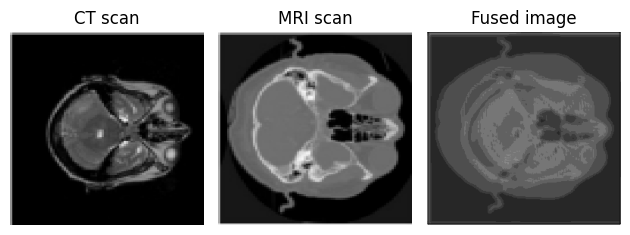

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the saved model
model = load_model("fusion_model.keras", compile=False)

def preprocess_image(img_path):
    # Load the image
    img = image.load_img(img_path, color_mode="grayscale", target_size=(256, 256))
    # Convert the image to array
    img_array = image.img_to_array(img)
    # Expand dimensions to match model input shape
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize the image
    img_array = img_array / 255.0
    return img_array

def predict_fused_image(ct_img_path, mri_img_path):
    # Preprocess the CT and MRI images
    ct_img = preprocess_image(ct_img_path)
    mri_img = preprocess_image(mri_img_path)
    # Predict the fused image
    fused_img = model.predict([ct_img, mri_img])
    # Denormalize the image
    fused_img = fused_img * 255.0
    # Convert to uint8
    fused_img = np.uint8(fused_img[0])
    return fused_img

# Paths to CT and MRI images
ct_image_path = "/Users/chintubharath/Documents/sdp/Imfusion-main/demo/medical1.png"
mri_image_path = "/Users/chintubharath/Documents/sdp/Imfusion-main/demo/medical2.png"

# Predict the fused image
fused_image = predict_fused_image(ct_image_path, mri_image_path)

# Display the images
import matplotlib.pyplot as plt

# Load and display CT image
ct_image = image.load_img(ct_image_path, color_mode="grayscale", target_size=(256, 256))
plt.subplot(1, 3, 1)
plt.imshow(ct_image, cmap='gray')
plt.title("CT scan")
plt.axis('off')

# Load and display MRI image
mri_image = image.load_img(mri_image_path, color_mode="grayscale", target_size=(256, 256))
plt.subplot(1, 3, 2)
plt.imshow(mri_image, cmap='gray')
plt.title("MRI scan")
plt.axis('off')

# Display the fused image
plt.subplot(1, 3, 3)
plt.imshow(fused_image, cmap='gray')
plt.title("Fused image")
plt.axis('off')

plt.tight_layout()
plt.show()


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import os

# Load the saved model
model = load_model("fusion_model.keras", compile=False)

def preprocess_image(img_path):
    # Load the image
    img = image.load_img(img_path, color_mode="grayscale", target_size=(256, 256))
    # Convert the image to array
    img_array = image.img_to_array(img)
    # Expand dimensions to match model input shape
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize the image
    img_array = img_array / 255.0
    return img_array

def predict_fused_image(ct_img_path, mri_img_path):
    # Preprocess the CT and MRI images
    ct_img = preprocess_image(ct_img_path)
    mri_img = preprocess_image(mri_img_path)
    # Predict the fused image
    fused_img = model.predict([ct_img, mri_img])
    # Denormalize the image
    fused_img = fused_img * 255.0
    # Convert to uint8
    fused_img = np.uint8(fused_img[0])
    return fused_img

# Paths to CT and MRI images
ct_image_path = "D:/SDP/Imfusion-main/screenshots/medical1.png"
mri_image_path = "D:/SDP/Imfusion-main/screenshots/medical2.png"

# Predict fused image
fused_image = predict_fused_image(ct_image_path, mri_image_path)

# Save the fused image
save_path = "D:/SDP/fused_images"
if not os.path.exists(save_path):
    os.makedirs(save_path)
image_name = "fused_image.png"
save_image_path = os.path.join(save_path, image_name)
image.save_img(save_image_path, fused_image)

print("Fused image saved at:", save_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
Fused image saved at: D:/SDP/fused_images\fused_image.png


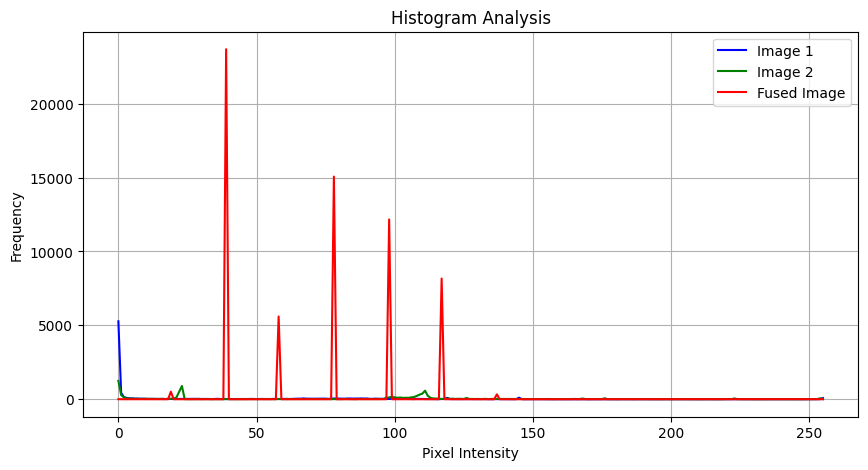

In [7]:
#ev-1


import cv2
import numpy as np
import matplotlib.pyplot as plt

def histogram_analysis(img1, img2, fused_img):
    # Convert images to grayscale
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    fused_img_gray = cv2.cvtColor(fused_img, cv2.COLOR_BGR2GRAY)

    # Calculate histograms
    hist1 = cv2.calcHist([img1_gray], [0], None, [256], [0,256])
    hist2 = cv2.calcHist([img2_gray], [0], None, [256], [0,256])
    hist_fused = cv2.calcHist([fused_img_gray], [0], None, [256], [0,256])

    # Plot histograms
    plt.figure(figsize=(10, 5))
    plt.plot(hist1, color='blue', label='Image 1')
    plt.plot(hist2, color='green', label='Image 2')
    plt.plot(hist_fused, color='red', label='Fused Image')
    plt.title('Histogram Analysis')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
img1_path = "D:/SDP/Imfusion-main/screenshots/medical1.png"
img2_path = "D:/SDP/Imfusion-main/screenshots/medical2.png"
fused_img_path = "D:/SDP/fused_images/fused_image.png"

img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
fused_img = cv2.imread(fused_img_path)

histogram_analysis(img1, img2, fused_img)

Feature - based 

In [1]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from scipy.stats import chi2

def feature_based_evaluation(img1, img2, fused_img):
    # Convert images to grayscale
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    fused_img_gray = cv2.cvtColor(fused_img, cv2.COLOR_BGR2GRAY)

    # Extract Local Binary Patterns (LBP) features
    radius = 1
    n_points = 8 * radius
    lbp1 = local_binary_pattern(img1_gray, n_points, radius, method='uniform')
    lbp2 = local_binary_pattern(img2_gray, n_points, radius, method='uniform')
    lbp_fused = local_binary_pattern(fused_img_gray, n_points, radius, method='uniform')

    # Calculate histograms of LBP features
    hist1, _ = np.histogram(lbp1.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist2, _ = np.histogram(lbp2.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist_fused, _ = np.histogram(lbp_fused.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

    # Compute Chi-Squared distance between histograms
    chi_squared_dist1 = np.sum(np.square(hist1 - hist_fused) / hist_fused)
    chi_squared_dist2 = np.sum(np.square(hist2 - hist_fused) / hist_fused)

    print("Chi-Squared Distance (Image 1 vs. Fused Image):", chi_squared_dist1)
    print("Chi-Squared Distance (Image 2 vs. Fused Image):", chi_squared_dist2)

# Example usage
img1_path = "D:/SDP/Imfusion-main/screenshots/medical1.png"
img2_path = "D:/SDP/Imfusion-main/screenshots/medical2.png"
fused_img_path = "D:/SDP/fused_images/fused_image.png"


img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
fused_img = cv2.imread(fused_img_path)

feature_based_evaluation(img1, img2, fused_img)


Chi-Squared Distance (Image 1 vs. Fused Image): inf
Chi-Squared Distance (Image 2 vs. Fused Image): inf


C:\Users\USER\AppData\Local\Temp\ipykernel_7192\2747604893.py:25: RuntimeWarning: divide by zero encountered in divide
  chi_squared_dist1 = np.sum(np.square(hist1 - hist_fused) / hist_fused)
C:\Users\USER\AppData\Local\Temp\ipykernel_7192\2747604893.py:26: RuntimeWarning: divide by zero encountered in divide
  chi_squared_dist2 = np.sum(np.square(hist2 - hist_fused) / hist_fused)


Frequency Domain

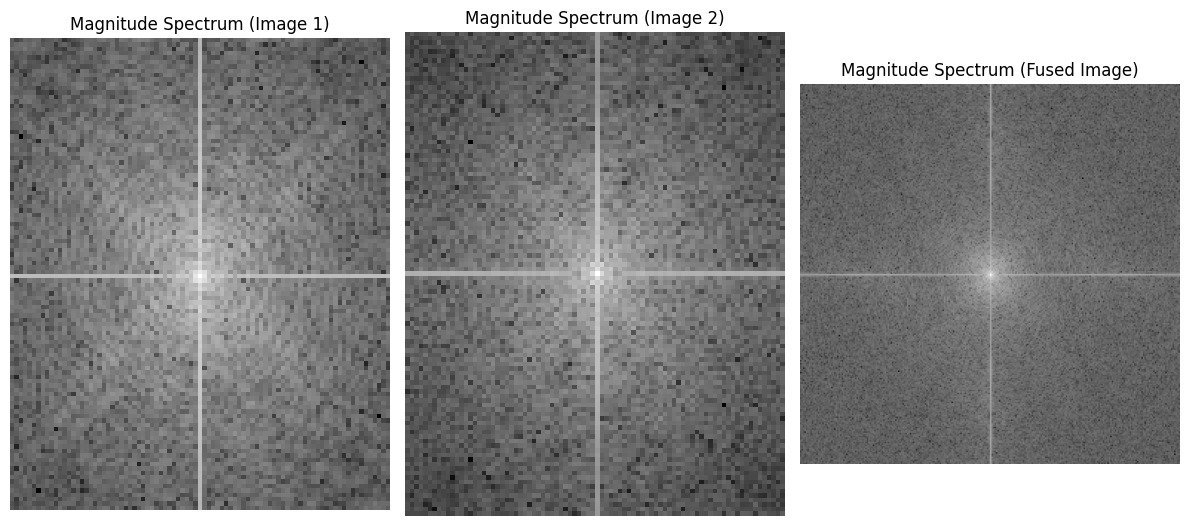

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def frequency_domain_analysis(img1, img2, fused_img):
    # Convert images to grayscale
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    fused_img_gray = cv2.cvtColor(fused_img, cv2.COLOR_BGR2GRAY)

    # Perform Fast Fourier Transform (FFT)
    fft_img1 = np.fft.fft2(img1_gray)
    fft_img2 = np.fft.fft2(img2_gray)
    fft_fused_img = np.fft.fft2(fused_img_gray)

    # Shift zero frequency component to the center
    fft_img1_shifted = np.fft.fftshift(fft_img1)
    fft_img2_shifted = np.fft.fftshift(fft_img2)
    fft_fused_img_shifted = np.fft.fftshift(fft_fused_img)

    # Calculate magnitude spectrum
    magnitude_spectrum_img1 = np.log(np.abs(fft_img1_shifted) + 1)
    magnitude_spectrum_img2 = np.log(np.abs(fft_img2_shifted) + 1)
    magnitude_spectrum_fused_img = np.log(np.abs(fft_fused_img_shifted) + 1)

    # Plot magnitude spectra
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(magnitude_spectrum_img1, cmap='gray')
    plt.title('Magnitude Spectrum (Image 1)')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(magnitude_spectrum_img2, cmap='gray')
    plt.title('Magnitude Spectrum (Image 2)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(magnitude_spectrum_fused_img, cmap='gray')
    plt.title('Magnitude Spectrum (Fused Image)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
img1_path = "D:/SDP/Imfusion-main/screenshots/medical1.png"
img2_path = "D:/SDP/Imfusion-main/screenshots/medical2.png"
fused_img_path = "D:/SDP/fused_images/fused_image.png"

img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
fused_img = cv2.imread(fused_img_path)

frequency_domain_analysis(img1, img2, fused_img)
